In [103]:
import numpy as np
from scipy import fftpack
import tensorly as tl
from util import square_tensor_gen, TensorInfoBucket, RandomInfoBucket, eval_mse, eval_rerr
from sketch import Sketch
import time
from tensorly.decomposition import tucker
from sketch_recover import SketchTwoPassRecover
from sketch_recover import SketchOnePassRecover
import matplotlib 
import matplotlib.pyplot as plt
from simulation import Simulation
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [9]:
n = 200
k = 12  
rank = 5 
dim = 3 
s = 80 
tensor_shape = np.repeat(n,dim)
noise_level = 0.01
gen_typ = 'id' 
Rinfo_bucket = RandomInfoBucket(random_seed = 1)
'''
simu = Simulation(tensor_shape, rank, k, s, Rinfo_bucket, gen_typ, noise_level)
_, rerr = simu.ho_svd()
print('ho_svd rerr:', rerr)
_, rerr = simu.two_pass() 
print('two_pass:', rerr) 
_, rerr = simu.one_pass()
print('one_pass:', rerr)
''' 

noise_levels = (np.float(10)**(np.arange(-10,2,2))) 
ho_svd_rerr = np.zeros(len(noise_levels))
two_pass_rerr = np.zeros(len(noise_levels))
one_pass_rerr = np.zeros(len(noise_levels))
one_pass_rerr_ns = np.zeros(len(noise_levels))

for idx, noise_level in enumerate(noise_levels): 
    print('Noise_level:', noise_level)
    simu = Simulation(tensor_shape, rank, k, s, Rinfo_bucket, gen_typ, noise_level)
    _, rerr = simu.ho_svd()
    #print('ho_svd rerr:', rerr) 
    ho_svd_rerr[idx] = rerr 

    _, rerr = simu.two_pass() 
    #print('two_pass:', rerr) 
    two_pass_rerr[idx] = rerr

    _, rerr = simu.one_pass()
    #print('one_pass:', rerr)
    one_pass_rerr[idx] = rerr

    _, rerr = simu.one_pass(store_phis = False) 
    one_pass_rerr_ns[idx]  = rerr


print("identity design with varying noise_level")
print("noise_levels", noise_levels)
print("ho_svd", ho_svd_rerr)
print("two_pass", two_pass_rerr)
print("one_pass", one_pass_rerr)
print("one_pass_ns", one_pass_rerr_ns)



Noise_level: 1e-10


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


Noise_level: 1e-08


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


Noise_level: 1e-06


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


Noise_level: 0.0001


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


Noise_level: 0.01


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


Noise_level: 1.0


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


identity design with varying noise_level
noise_levels [1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00]
ho_svd [9.99586450e-06 9.99586424e-05 9.99585726e-04 9.99534240e-03
 9.94605642e-02 7.06813511e-01]
two_pass [1.67859698e-05 1.67859603e-04 1.67858492e-03 1.67831370e-02
 1.65987030e-01 9.13304710e-01]
one_pass [1.77600227e-05 1.77600390e-04 1.77601837e-03 1.77598033e-02
 1.75755666e-01 9.31561342e-01]
one_pass_ns [1.77600227e-05 1.77600390e-04 1.77601837e-03 1.77598033e-02
 1.75755666e-01 9.31561342e-01]


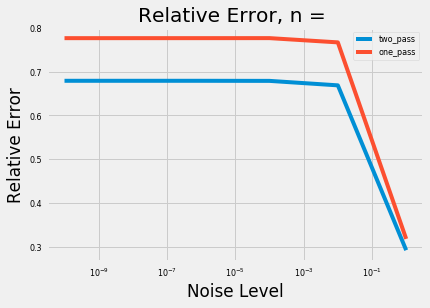

In [21]:
plt.figure()
# plt.plot(noise_levels,ho_svd_rerr,label = 'ho_svd') 
# plt.title('ho_svd')
plt.plot(noise_levels,two_pass_rerr/ho_svd_rerr-1, label = 'two_pass')
plt.title('two_pass')
plt.plot(noise_levels,one_pass_rerr/ho_svd_rerr-1, label = 'one_pass') 
plt.title('one_pass')
plt.xscale('log')
plt.xscale('log')
plt.legend(loc = 'best')
plt.title('Relative Error, n = ')
plt.xlabel('Noise Level')
plt.ylabel('Relative Error')
plt.show()

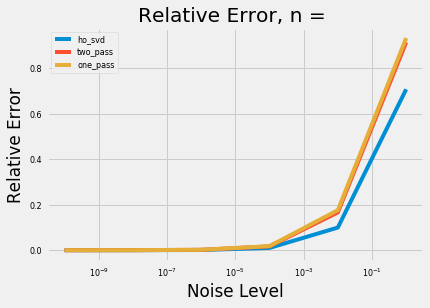

In [22]:
plt.figure()
plt.plot(noise_levels,ho_svd_rerr,label = 'ho_svd') 
plt.title('ho_svd')
plt.plot(noise_levels,two_pass_rerr, label = 'two_pass')
plt.title('two_pass')
plt.plot(noise_levels,one_pass_rerr, label = 'one_pass') 
plt.title('one_pass')
plt.xscale('log')
plt.xscale('log')
plt.legend(loc = 'best')
plt.title('Relative Error, n = ')
plt.xlabel('Noise Level')
plt.ylabel('Relative Error')
plt.show()

In [ ]:
gen_types = ['id', 'id1', 'id2', 'spd', 'fpd', 'sed', 'fed', 'lk']
rs = [1,5]
dim = 3

In [104]:
gen_types = ['id','id1','id2']

In [105]:
def plot_row(gen_type,r,noise_level,name, ns = np.arange(100,201,100), dim = 3, sim_runs = 1):
    plt.close()
    plt.figure(figsize = (len(ns)*5,5))
    for plot_id, n in enumerate(ns): 
        random_seed = np.random.randint(1000000) 
        ks =np.arange(r, int(n/2),int(n/20)) 
        ho_svd_rerr = np.zeros(len(ks))
        two_pass_rerr = np.zeros(len(ks))
        one_pass_rerr = np.zeros(len(ks))
        for idx, k in enumerate(ks): 
            simu = Simulation(np.repeat(n,dim), r, k, 2*k, RandomInfoBucket(random_seed), gen_typ, noise_level)
            _, rerr = simu.ho_svd()
            ho_svd_rerr[idx] = rerr 
            _, rerr = simu.two_pass() 
            two_pass_rerr[idx] = rerr
            _, rerr = simu.one_pass()
            one_pass_rerr[idx] = rerr 
        print(ho_svd_rerr)
        print(two_pass_rerr)
        print(one_pass_rerr)
        plt.subplot(1,len(ns),plot_id+1) 
        plt.plot(ks,two_pass_rerr/ho_svd_rerr - 1, label = 'two_pass')
        plt.title('two_pass')
        plt.plot(ks,one_pass_rerr/ho_svd_rerr - 1, label = 'one_pass') 
        plt.title('one_pass') 
        plt.legend(loc = 'best')
        plt.title("n = %s"%(n))
        plt.xlabel('k')
        plt.ylabel('Relative Error')
        plt.yscale('log')
        plt.axis('equal')
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()
        
        

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09940142 0.09936891 0.0994262  0.09934864 0.09950484 0.09936295
 0.09946945 0.09932853 0.0994221 ]
[0.57362417 0.18181056 0.16900382 0.1350224  0.12332714 0.12117483
 0.11492974 0.11291024 0.10882162]
[0.7016103  0.31920451 0.21297773 0.16841588 0.15273455 0.13859141
 0.12833323 0.12018961 0.1183515 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09949134 0.09949394 0.09950663 0.09947083 0.09947555 0.09948849
 0.09946178 0.09951521 0.09945164 0.09945248]
[0.56965096 0.15834275 0.12923606 0.12166642 0.11110023 0.11023827
 0.10726943 0.10667179 0.10492795 0.1037461 ]
[0.90751844 0.18849257 0.1580094  0.13475505 0.12760159 0.12116538
 0.11548648 0.11245151 0.10947013 0.10706663]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09948211 0.09949758 0.09949635 0.0994929  0.09949824 0.09949928
 0.09949658 0.09948739 0.09949817 0.09949731]
[0.54915917 0.14455642 0.11895501 0.11331374 0.10915215 0.10701181
 0.10471491 0.10426837 0.10281554 0.10239527]
[0.86480111 0.18859106 0.14025028 0.12589608 0.11787212 0.11517704
 0.10990605 0.10793762 0.10650799 0.10495502]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


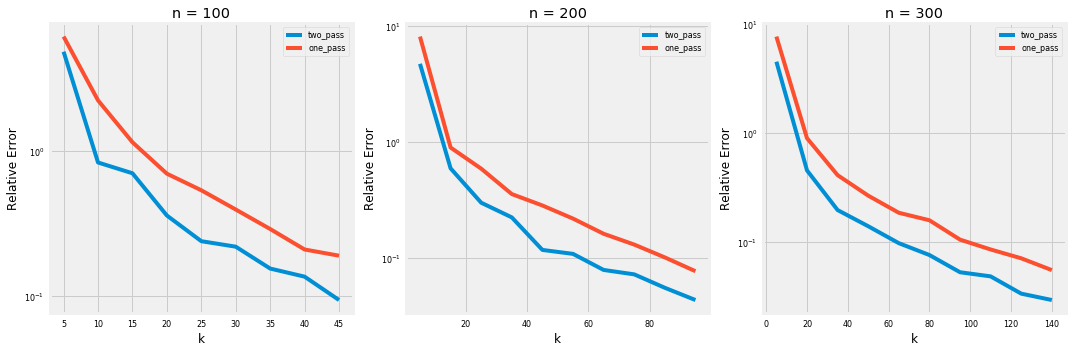

In [106]:
plot_row('id',5,0.01,"plot1.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[9.42261530e-16 6.82906149e-16 1.21290278e-15 1.19463220e-15
 1.09665467e-15 1.44725044e-15 7.90787885e-16 1.04096739e-15
 9.84682653e-16]
[4.62208683e-16 1.11977323e-15 8.85975873e-16 1.25294130e-15
 1.50204512e-15 1.28096475e-15 1.18438596e-15 1.56723638e-15
 1.10810221e-15]
[1.56425262e-15 3.11321567e-15 3.68476449e-15 3.12935755e-15
 2.98520957e-15 3.49031765e-15 3.61638532e-15 4.49789491e-15
 4.32603679e-15]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[1.30885975e-15 1.13572120e-15 8.52869539e-16 1.03216206e-15
 8.13878195e-16 1.11439165e-15 1.34726130e-15 1.10381380e-15
 1.28407208e-15 9.16712498e-16]
[1.12259267e-15 1.08689243e-15 1.22050662e-15 9.06472277e-16
 1.52672693e-15 1.35633263e-15 9.34867818e-16 9.93393391e-16
 1.59686803e-15 8.76962039e-16]
[1.26240055e-15 2.60757567e-15 3.92458028e-15 3.80469404e-15
 3.77089626e-15 4.03041886e-15 4.60412219e-15 4.54992577e-15
 4.18000151e-15 4.77981343e-15]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[5.14326844e-16 9.74930315e-16 8.57489144e-16 1.05154756e-15
 9.80429046e-16 7.99166250e-16 7.62967410e-16 1.08182079e-15
 7.60688230e-16 7.57216303e-16]
[5.80513396e-16 1.14500111e-15 1.20943817e-15 1.43961434e-15
 1.14763410e-15 9.64314667e-16 1.68357442e-15 1.19270397e-15
 1.61931342e-15 1.59914811e-15]
[2.23546705e-15 3.83176099e-15 3.62740289e-15 4.77195279e-15
 4.07964631e-15 4.19022950e-15 4.50127483e-15 4.53337022e-15
 4.71132980e-15 5.04381674e-15]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


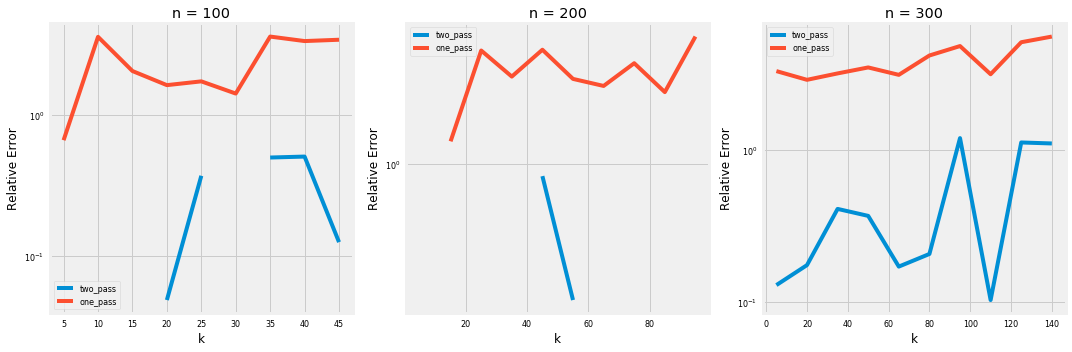

In [107]:
plot_row('id',5,0,"plot2.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.7063529  0.70599693 0.70719778 0.706059   0.70704772 0.70663463
 0.70599752 0.70704982 0.70657486]
[0.98076493 0.94859894 0.87982306 0.85581976 0.84114318 0.79601013
 0.78615319 0.77285626 0.76586388]
[1.28445614 1.26140117 1.16633491 0.99068406 1.01382397 0.91438804
 0.84458484 0.84375297 0.8362271 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.70691106 0.70676607 0.70677104 0.7068395  0.70682635 0.70704176
 0.7070134  0.70704692 0.70704121 0.70715844]
[0.97954908 0.89222246 0.83927018 0.81394862 0.79211723 0.77016996
 0.75317651 0.74865628 0.73904551 0.73475016]
[2.05658785 1.11922237 0.95324293 0.89920241 0.8637068  0.82596364
 0.80923825 0.78797398 0.77924518 0.76289842]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.70696759 0.70696806 0.70715743 0.70709659 0.7070985  0.70704319
 0.7071186  0.70690428 0.70714618 0.70693132]
[0.9875814  0.89011329 0.81746535 0.78397113 0.76608867 0.75198962
 0.74542045 0.7381601  0.73120887 0.72707852]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


[1.56490227 1.09395287 0.92998927 0.86934335 0.82426741 0.80404313
 0.77317181 0.76549239 0.75508166 0.7436818 ]


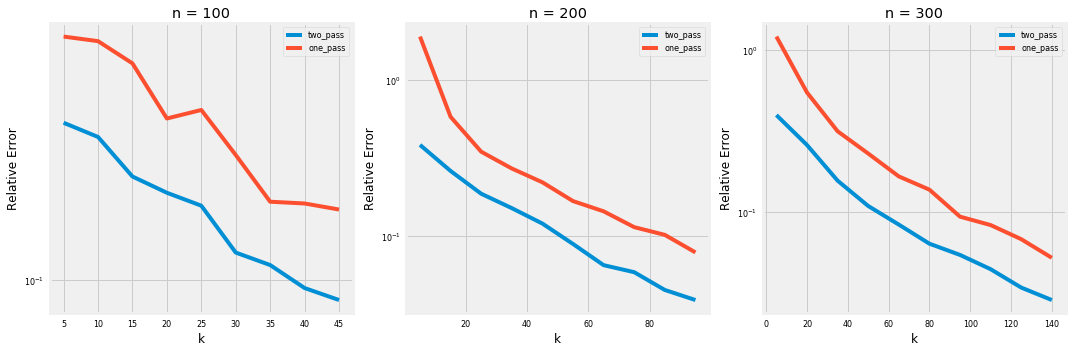

In [108]:
plot_row('id',5,1,"plot3.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09951338 0.09946841 0.09949565 0.09951966 0.09945738 0.09949104
 0.09960949 0.09937173 0.09945666 0.09946953]
[0.52110246 0.13845005 0.10949906 0.1081718  0.10525531 0.10289272
 0.10281486 0.10307081 0.10157874 0.101506  ]
[1.21813439 0.16125781 0.13206991 0.11253477 0.11033648 0.10968907
 0.10621427 0.10560988 0.10382193 0.1025282 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09949923 0.0994818  0.0995208  0.0995011  0.09946765 0.0995226
 0.09953641 0.09947271 0.09949048 0.0994834 ]
[0.53741143 0.11032397 0.10548972 0.10336348 0.10228349 0.10186543
 0.10133667 0.10111363 0.10051974 0.10045254]
[1.3487366  0.11977153 0.10908896 0.10770524 0.10463475 0.10356428
 0.10294122 0.1024161  0.10137564 0.10118328]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09950569 0.09951298 0.09947873 0.09949732 0.09948573 0.0995261
 0.09948698 0.09951274 0.099521   0.09950891]
[0.2414275  0.11048763 0.10396963 0.10302721 0.10171548 0.10122393
 0.10067327 0.1003771  0.10037316 0.10012832]
[0.26029972 0.11514859 0.1075601  0.10595773 0.10364777 0.10231689
 0.10162899 0.10159048 0.10103958 0.10079026]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


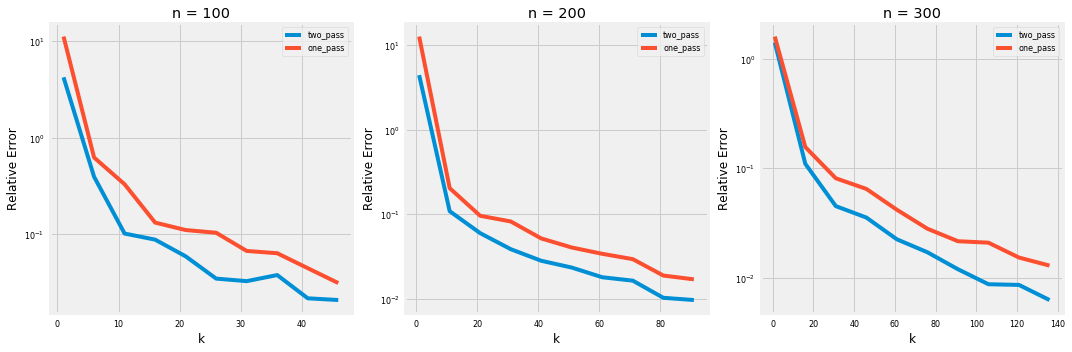

In [109]:
plot_row('id',1,0.01,"plot4.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09940394 0.09945037 0.09930129 0.09945176 0.09946513 0.09949301
 0.09930667 0.09955584 0.09935911]
[0.63114763 0.22284936 0.1678645  0.13793271 0.12353169 0.11845003
 0.11309835 0.11152364 0.11037873]
[0.63723126 0.28456841 0.19013058 0.17092655 0.14693801 0.13396873
 0.12537045 0.12520639 0.1200342 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09948938 0.09948352 0.09946964 0.0994868  0.09945532 0.09949834
 0.09946993 0.09949856 0.09949698 0.09950923]
[0.61332113 0.15413127 0.13239131 0.11865827 0.11376654 0.10982701
 0.1070024  0.10592352 0.10411632 0.10403604]
[0.63096614 0.20683165 0.16090225 0.13619594 0.12595329 0.11824679
 0.11559826 0.11323559 0.11020126 0.1083597 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09951557 0.09950156 0.09948289 0.09952358 0.09951301 0.09949239
 0.09950445 0.09950368 0.0995051  0.09947011]
[0.37784949 0.14493071 0.11951542 0.11152595 0.1085248  0.10643629
 0.10495419 0.10375037 0.10323654 0.10253094]
[0.96897757 0.17058693 0.13805772 0.12552562 0.1197145  0.11106456
 0.11052526 0.10836912 0.10675015 0.10507885]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


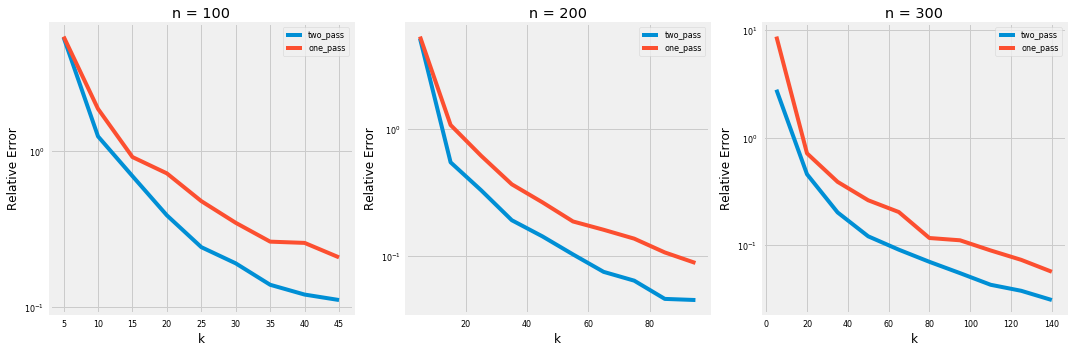

In [110]:
plot_row('spd',5,0.01,"plot5.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09947953 0.0994926  0.0994152  0.09948105 0.09935337 0.09937377
 0.09932587 0.09954195 0.09941255]
[0.6321963  0.20154755 0.15147516 0.12968208 0.1246867  0.11831783
 0.11315466 0.11308297 0.10883987]
[0.94675109 0.30921064 0.17895951 0.16745223 0.15347427 0.13376469
 0.13363432 0.12008783 0.11869733]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09948398 0.09946516 0.09947554 0.09949773 0.09946001 0.09948299
 0.09953366 0.09948986 0.0994694  0.09947817]
[0.5919182  0.1498934  0.13369345 0.1215234  0.11329405 0.1100681
 0.10731017 0.10653617 0.10486375 0.10386245]
[0.70972007 0.22319516 0.16107015 0.13325229 0.12828053 0.11863731
 0.11523743 0.11200792 0.10932051 0.1079836 ]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09948749 0.09951531 0.09946763 0.09950119 0.09945914 0.09949558
 0.09950691 0.09953422 0.09948068 0.09949528]
[0.58765085 0.14347119 0.11902471 0.11353471 0.10865271 0.10601096
 0.10491997 0.10375275 0.10301777 0.10238136]
[0.71814275 0.16571594 0.13755679 0.12562335 0.11861985 0.11355094
 0.11128922 0.10933623 0.10666571 0.10502093]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


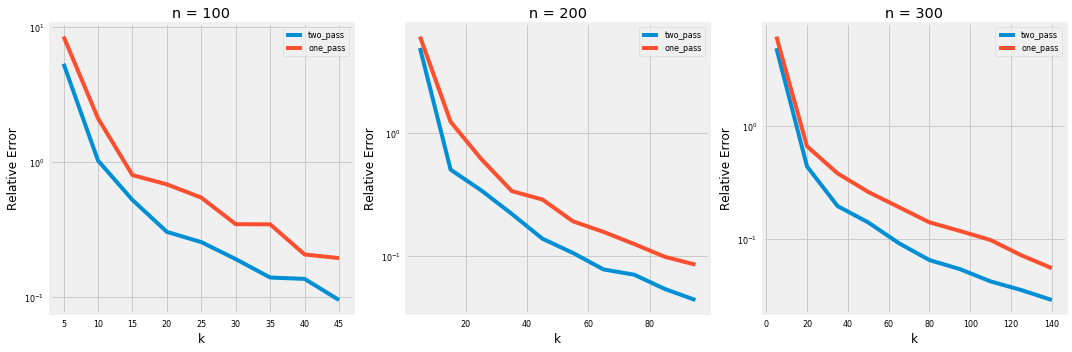

In [111]:
plot_row('fpd',5,0.01,"plot6.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09951983 0.09939753 0.09940819 0.09939186 0.0993803  0.09949291
 0.09957719 0.09938682 0.09932296]
[0.51282843 0.17443955 0.14317806 0.13745993 0.12545013 0.11596146
 0.11467632 0.11136508 0.11027101]
[0.8608213  0.25359699 0.20941647 0.16294288 0.1437641  0.13713008
 0.12764874 0.12021812 0.12180956]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09944683 0.09949343 0.09949549 0.0994629  0.09949019 0.09947076
 0.0995213  0.09947663 0.09948271 0.09950082]
[0.53016463 0.16050404 0.12886026 0.1182173  0.11291576 0.11041643
 0.1081368  0.10622067 0.104631   0.10390793]
[0.62576877 0.20917311 0.155437   0.13677626 0.12787235 0.11994191
 0.11605444 0.11241135 0.11039737 0.10802598]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09949414 0.09949525 0.09950939 0.09947019 0.09948569 0.09947531
 0.09950883 0.09950281 0.09950886 0.09949481]
[0.61512001 0.14179047 0.11924522 0.11354845 0.10943953 0.1073531
 0.10496965 0.10401297 0.10292538 0.10236708]
[0.76430464 0.18383875 0.13609208 0.12391164 0.11725746 0.11393357
 0.11104676 0.10817876 0.1063839  0.10552133]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


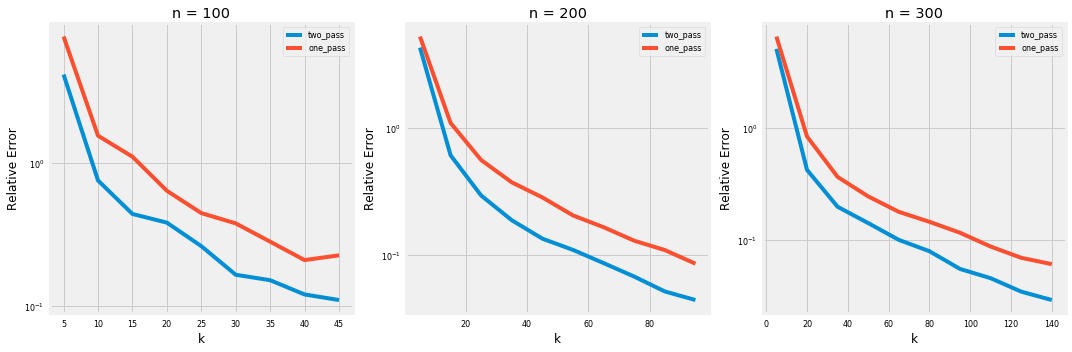

In [112]:
plot_row('sed',5,0.01,"plot7.pdf",ns = np.arange(100,301,100), sim_runs = 1)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[0.09933631 0.09942948 0.09944836 0.09948009 0.09967611 0.09939235
 0.09936279 0.09945656 0.09947301]
[0.58493732 0.19098343 0.14422973 0.13880851 0.12505471 0.12105331
 0.11375082 0.11164145 0.10861227]
[0.96387775 0.34930533 0.20643663 0.16693613 0.14627551 0.13608166
 0.1290577  0.12727539 0.11587368]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09948077 0.09948258 0.09950776 0.09950744 0.09950878 0.09948457
 0.09947746 0.09949369 0.09953612 0.09946413]
[0.64781275 0.15867537 0.12717838 0.11788234 0.11306741 0.10955642
 0.10701343 0.10549007 0.10454182 0.10358294]
[0.73019407 0.1793281  0.15576437 0.13699766 0.12531337 0.12096543
 0.11777878 0.11194996 0.10967067 0.10734653]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[0.09947448 0.09948103 0.0995059  0.09948355 0.09950744 0.09950351
 0.09948712 0.09951351 0.09951644 0.09950569]
[0.62907826 0.13572938 0.12234684 0.11272786 0.10829629 0.1067582
 0.10505554 0.10407069 0.10311515 0.10251559]
[0.57396359 0.17345802 0.14190677 0.12666018 0.11707153 0.11359497
 0.1108036  0.10852684 0.1059303  0.10495342]


/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


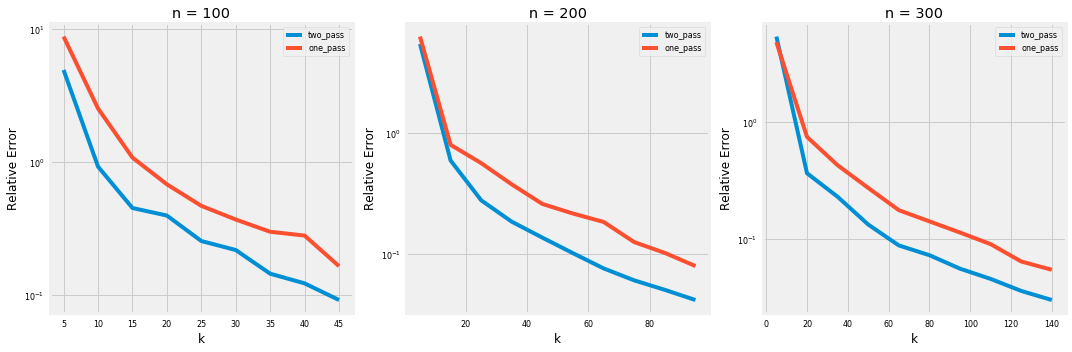

In [113]:
plot_row('fed',5,0.01,"plot8.pdf",ns = np.arange(100,301,100), sim_runs = 1)